# Backtesting the Ichimoku Cloud Trading Strategy

## Install and Import Libraries

In [92]:
%pip install yfinance matplotlib tabulate -q

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\medium\articles\ichimoku_cloud_trading_strategy\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [93]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

## Download Data

In [94]:
# Download historical stock data
symbol = "AAPL"  # You can change to BTC-USD, TSLA, etc.
data = yf.download(symbol, start="2020-01-01", end="2024-12-31")

# Select the desired columns (first level of MultiIndex)
data.columns = data.columns.get_level_values(0)

data.head()

C:\Users\Brian\AppData\Local\Temp\ipykernel_9240\3976254313.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.538506,72.598884,71.292296,71.545882,135480400
2020-01-03,71.833282,72.594048,71.608677,71.765659,146322800
2020-01-06,72.405708,72.444351,70.703042,70.954218,118387200
2020-01-07,72.065147,72.671341,71.845369,72.415337,108872000
2020-01-08,73.224388,73.526280,71.768064,71.768064,132079200


## Plot Closing Price

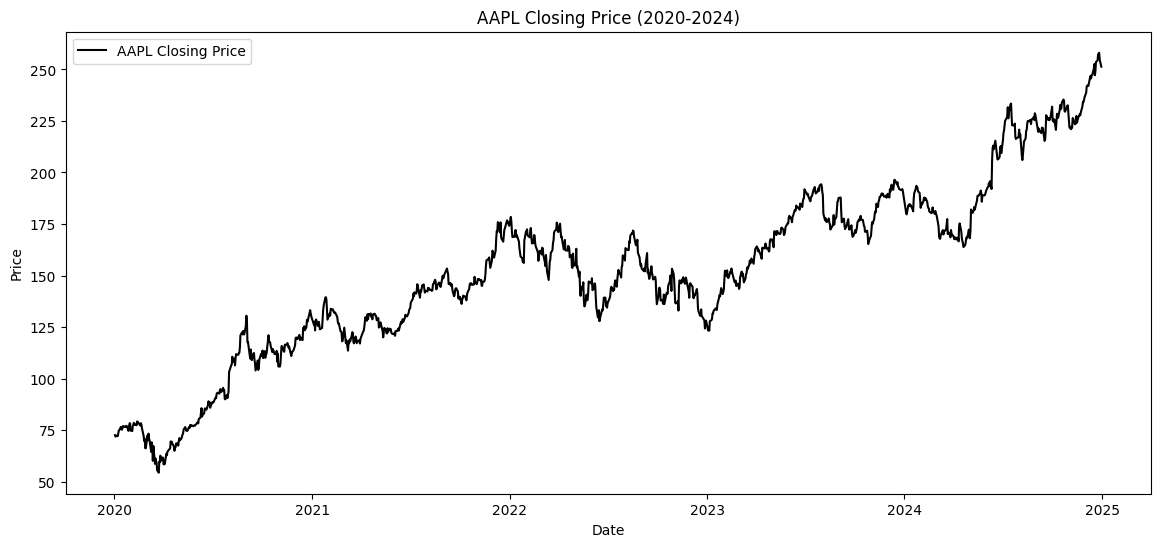

In [95]:
# Plot closing price only
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Close'], label=f"{symbol} Closing Price", color="black", linewidth=1.5)
plt.title(f"{symbol} Closing Price (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.savefig(f"figures/{symbol}_closing_price.png", dpi=300)
plt.show()

## Calculate Ichimoku Components

In [96]:
# Ichimoku settings (standard: 9, 26, 52)
high = data['High']
low = data['Low']
close = data['Close']

# Tenkan-sen (Conversion Line): (9-period high + 9-period low) / 2
data['tenkan'] = (high.rolling(9).max() + low.rolling(9).min()) / 2

# Kijun-sen (Base Line): (26-period high + 26-period low) / 2
data['kijun'] = (high.rolling(26).max() + low.rolling(26).min()) / 2

# Senkou Span A (Leading Span A): (tenkan + kijun) / 2, shifted 26 periods forward
data['senkou_a'] = ((data['tenkan'] + data['kijun']) / 2).shift(26)

# Senkou Span B (Leading Span B): (52-period high + 52-period low) / 2, shifted 26 periods forward
data['senkou_b'] = ((high.rolling(52).max() + low.rolling(52).min()) / 2).shift(26)

# Chikou Span (Lagging Span): closing price shifted -26 periods
data['chikou'] = close.shift(-26)

## Plot the Ichimoku Cloud

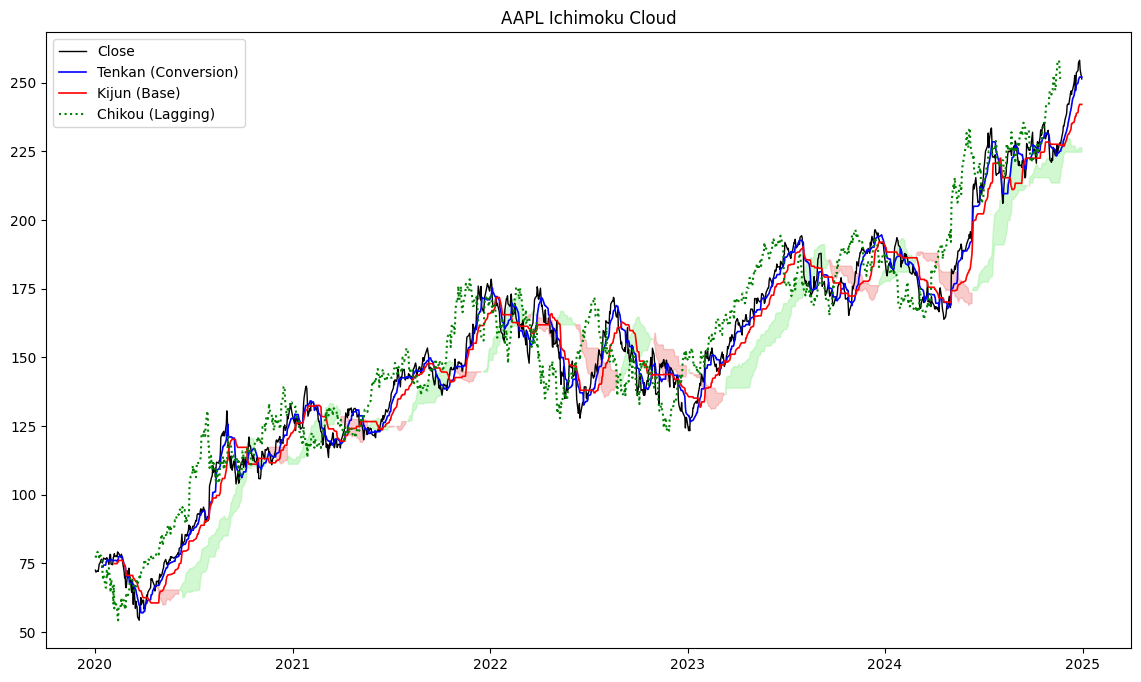

In [97]:
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Close'], label="Close", color='black', linewidth=1)

# Tenkan & Kijun
plt.plot(data.index, data['tenkan'], label="Tenkan (Conversion)", color='blue', linewidth=1.2)
plt.plot(data.index, data['kijun'], label="Kijun (Base)", color='red', linewidth=1.2)

# Cloud area
plt.fill_between(
    data.index, data['senkou_a'], data['senkou_b'],
    where=data['senkou_a'] >= data['senkou_b'],
    color='lightgreen', alpha=0.4
)
plt.fill_between(
    data.index, data['senkou_a'], data['senkou_b'],
    where=data['senkou_a'] < data['senkou_b'],
    color='lightcoral', alpha=0.4
)

# Chikou
plt.plot(data.index, data['chikou'], label="Chikou (Lagging)", color='green', linestyle='dotted')

plt.title(f"{symbol} Ichimoku Cloud")
plt.legend(loc="upper left")
plt.savefig(f"figures/{symbol}_ichimoku_cloud.png", dpi=300)
plt.show()


## Define a Simple Strategy

In [98]:
# Strategy: Buy when price closes above cloud and Tenkan crosses above Kijun
data['above_cloud'] = data['Close'] > data[['senkou_a', 'senkou_b']].max(axis=1)
data['tenkan_cross'] = (data['tenkan'] > data['kijun']) & (data['tenkan'].shift(1) <= data['kijun'].shift(1))

data['signal'] = 0
data.loc[data['above_cloud'] & data['tenkan_cross'], 'signal'] = 1  # Buy signal

## Visualize Trade Signals

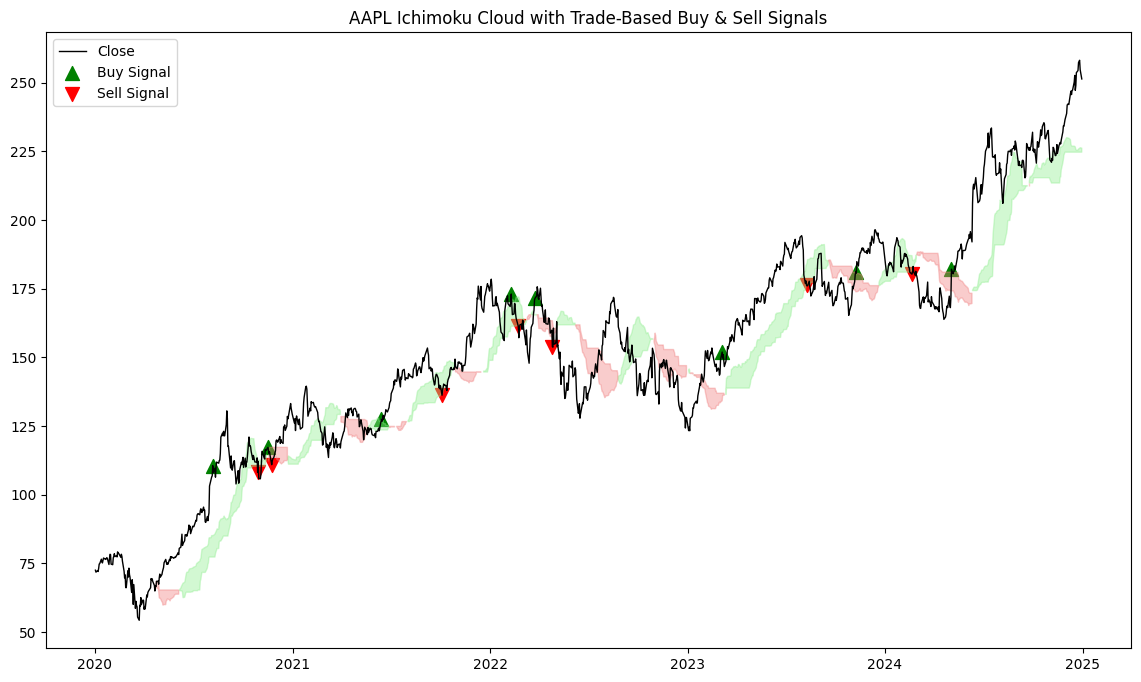

In [99]:
# Find trades: buy → sell pairs
buy_points = []
sell_points = []
position = 0  # 0 = flat, 1 = long

for i in range(len(data)):
    if data['signal'].iloc[i] == 1 and position == 0:
        buy_points.append((data.index[i], data['Close'].iloc[i]))
        position = 1
    elif position == 1 and data['Close'].iloc[i] < data[['senkou_a','senkou_b']].min(axis=1).iloc[i]:
        sell_points.append((data.index[i], data['Close'].iloc[i]))
        position = 0

# Convert to DataFrames for plotting
buy_df = pd.DataFrame(buy_points, columns=["Date","Price"]).set_index("Date")
sell_df = pd.DataFrame(sell_points, columns=["Date","Price"]).set_index("Date")

# Plot with clean trade-based signals
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Close'], color='black', linewidth=1, label="Close")

plt.scatter(buy_df.index, buy_df['Price'], marker="^", color="green", s=100, label="Buy Signal")
plt.scatter(sell_df.index, sell_df['Price'], marker="v", color="red", s=100, label="Sell Signal")

# Cloud
plt.fill_between(
    data.index, data['senkou_a'], data['senkou_b'],
    where=data['senkou_a'] >= data['senkou_b'],
    color='lightgreen', alpha=0.4
)
plt.fill_between(
    data.index, data['senkou_a'], data['senkou_b'],
    where=data['senkou_a'] < data['senkou_b'],
    color='lightcoral', alpha=0.4
)

plt.title(f"{symbol} Ichimoku Cloud with Trade-Based Buy & Sell Signals")
plt.legend()
plt.savefig(f"figures/{symbol}_trade_signals.png", dpi=300)
plt.show()

## Backtest the Strategy (Equity Curve)

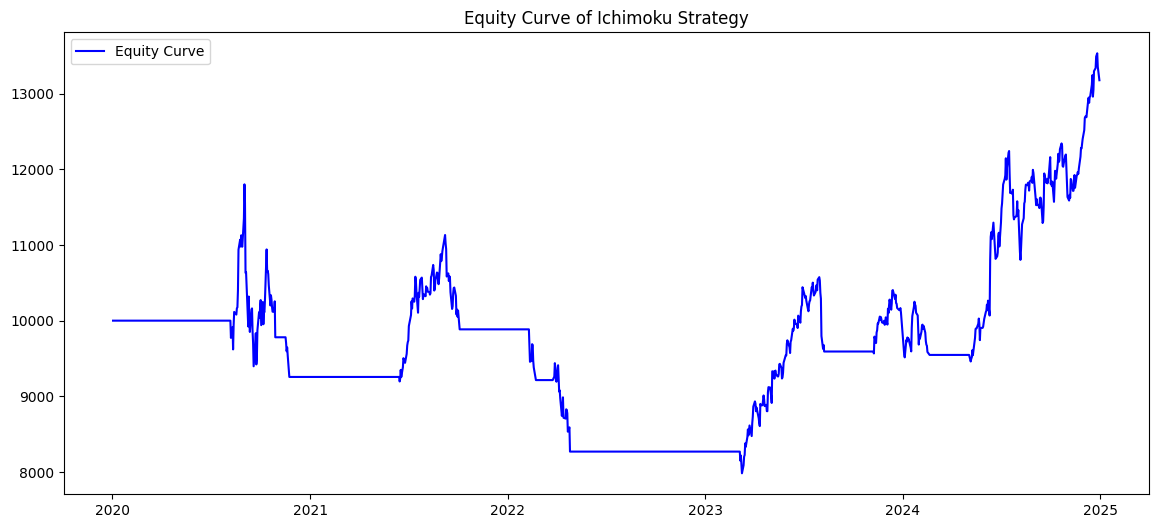

In [100]:
# Backtest parameters
initial_balance = 10000
position = 0
balance = initial_balance
equity_curve = []

for i in range(len(data)):
    # Buy condition
    if data['signal'].iloc[i] == 1 and position == 0:
        position = balance / data['Close'].iloc[i]
        balance = 0
    
    # Sell condition: price closes below the cloud
    elif position > 0 and data['Close'].iloc[i] < data[['senkou_a', 'senkou_b']].min(axis=1).iloc[i]:
        balance = position * data['Close'].iloc[i]
        position = 0
    
    # Track portfolio value
    equity_curve.append(balance + position * data['Close'].iloc[i])

data['equity'] = equity_curve

# Plot equity curve
plt.figure(figsize=(14,6))
plt.plot(data.index, data['equity'], label="Equity Curve", color="blue")
plt.title("Equity Curve of Ichimoku Strategy")
plt.legend()
plt.savefig(f"figures/{symbol}_equity_curve.png", dpi=300)
plt.show()


## Performance stats

In [101]:
final_balance = data['equity'].iloc[-1]
total_return = (final_balance - initial_balance) / initial_balance * 100
max_equity = data['equity'].cummax()
drawdown = (data['equity'] - max_equity) / max_equity
max_drawdown = drawdown.min() * 100

stats = [
    ["Initial Balance", f"${initial_balance:,.2f}"],
    ["Final Balance", f"${final_balance:,.2f}"],
    ["Total Return", f"{total_return:.2f}%"],
    ["Max Drawdown", f"{max_drawdown:.2f}%"],
]

print(tabulate(stats, headers=["Metric", "Value"], tablefmt="rounded_outline"))

╭─────────────────┬────────────╮
│ Metric          │ Value      │
├─────────────────┼────────────┤
│ Initial Balance │ $10,000.00 │
│ Final Balance   │ $13,177.42 │
│ Total Return    │ 31.77%     │
│ Max Drawdown    │ -32.36%    │
╰─────────────────┴────────────╯


## Visualize Drawdown

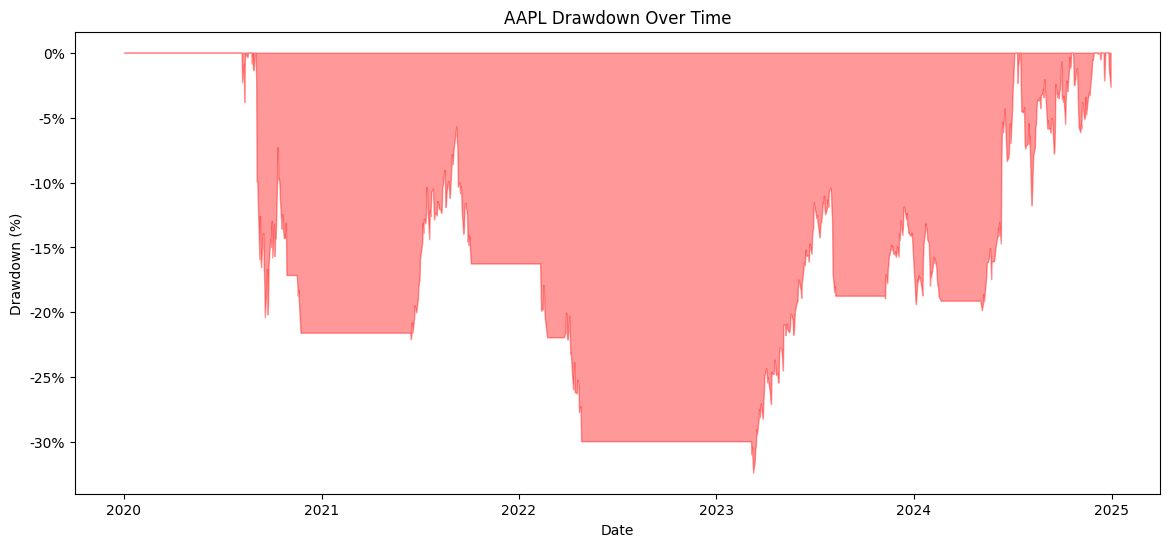

In [102]:
# Calculate drawdown
max_equity = data['equity'].cummax()              # Running peak
drawdown = (data['equity'] - max_equity) / max_equity  # % drop from peak

# Plot drawdown
plt.figure(figsize=(14,6))
plt.fill_between(data.index, drawdown, 0, color='red', alpha=0.4)
plt.title(f"{symbol} Drawdown Over Time")
plt.ylabel("Drawdown (%)")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
plt.savefig(f"figures/{symbol}_drawdown.png", dpi=300)
plt.show()

## Highlight Max Drawdown

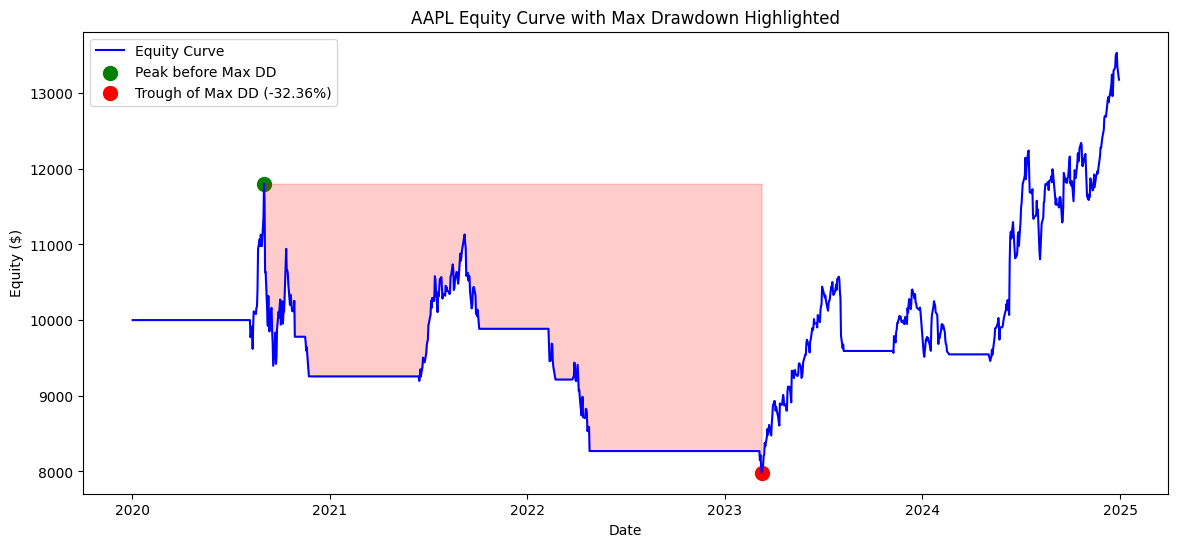

In [103]:
# Calculate running peak and drawdown
peak = data['equity'].cummax()
drawdown = (data['equity'] - peak) / peak

# Find max drawdown
max_dd_idx = drawdown.idxmin()               # Date of max drawdown
peak_before_dd_idx = data['equity'][:max_dd_idx].idxmax()  # Peak before drawdown
max_dd_value = drawdown.min() * 100

# Plot equity curve
plt.figure(figsize=(14,6))
plt.plot(data.index, data['equity'], label="Equity Curve", color="blue")

# Highlight peak before max drawdown
plt.scatter(peak_before_dd_idx, data['equity'][peak_before_dd_idx], color="green", s=100, label="Peak before Max DD")

# Highlight trough of max drawdown
plt.scatter(max_dd_idx, data['equity'][max_dd_idx], color="red", s=100, label=f"Trough of Max DD ({max_dd_value:.2f}%)")

# Shade max drawdown area
plt.fill_between(data.index, data['equity'], peak, where=(data.index>=peak_before_dd_idx)&(data.index<=max_dd_idx), color='red', alpha=0.2)

plt.title(f"{symbol} Equity Curve with Max Drawdown Highlighted")
plt.xlabel("Date")
plt.ylabel("Equity ($)")
plt.legend()
plt.savefig(f"figures/{symbol}_max_drawdown.png", dpi=300)
plt.show()
